### User Generosity Weights Feature Generator

- Goal: Quantify how lenient or strict each user's rating behaviour is.
- Compute each user's average rating across all their reviews.
- Identify harshest and most generous raters across users.
- Apply min-max normalisation to rescale user means to a [0, 1] generosity score.
- Optionally include number of reviews per user to gauge reliability.
- Save per-user table (user_id, mean_rating, n_reviews, generosity_weight).
- Use later as a user-level feature in NCF or to adjust rating bias.

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# Paths
ROOT = Path("../..").resolve()
DATA_PROCESSED = ROOT / "data" / "processed"
OUT_DIR = DATA_PROCESSED / "features" / "usergen"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Intake
splits = ["train", "test", "val"]
reviews_df = pd.concat([
    pd.read_parquet(DATA_PROCESSED / f"{split}.parquet")
    for split in splits
], ignore_index=True)

reviews_df['user_id'] = reviews_df['user_id'].astype(str)

print("\n✅ Loaded reviews_df")
print(f"Shape: {reviews_df.shape}")
print(f"Columns: {reviews_df.columns.tolist()}")
print("Sample rows:")
print(reviews_df.head(5))
print("Total reviews:", reviews_df.shape[0])
print("Unique users:", reviews_df['user_id'].nunique())


In [ ]:
user_ids_ordered = sorted(reviews_df['user_id'].unique())

user_stats = (
    reviews_df
    .groupby('user_id')
    .agg(
        mean_rating=('rating', 'mean'),
        n_reviews=('rating', 'count')
    )
    .reindex(user_ids_ordered)
    .reset_index()
)

print(user_stats.shape)
print("user_ids_ordered:", len(user_ids_ordered))

(1048204, 3)
user_ids_ordered: 1048204


In [ ]:
user_stats['user_encoded'] = pd.Series(range(len(user_stats)))

In [ ]:
log_conf = np.log1p(user_stats['n_reviews'])
log_conf /= log_conf.max()
confidence_floor = 0.3
user_stats['confidence'] = confidence_floor + (1 - confidence_floor) * log_conf

min_rating = user_stats['mean_rating'].min()
max_rating = user_stats['mean_rating'].max()
rating_range = max_rating - min_rating
user_stats['generosity'] = (user_stats['mean_rating'] - min_rating) / rating_range

user_stats['generosity_weight'] = user_stats['generosity'] * user_stats['confidence']

# 🔍 Inspect user_stats
print(f"Shape: {user_stats.shape}")
print(f"Columns: {user_stats.columns.tolist()}")
print("Sample rows:")
print(user_stats.head(5))

# Save output
user_stats.to_parquet(OUT_DIR / "user_generosity_weights.parquet", index=False)


✅ Generated user_stats
Shape: (1048204, 6)
Columns: ['user_id', 'mean_rating', 'n_reviews', 'confidence', 'generosity', 'generosity_weight']
Sample rows:
                  user_id  mean_rating  n_reviews  confidence  generosity  \
0   1.000000127957533e+20     3.600000         10    0.536494    0.650000   
1  1.0000002962130218e+20     4.428571          7    0.505086    0.857143   
2  1.0000003646453036e+20     4.510638         47    0.681800    0.877660   
3  1.0000007455270173e+20     4.833333          6    0.491917    0.958333   
4  1.0000007803905597e+20     4.583333         12    0.552970    0.895833   

   generosity_weight  
0           0.348721  
1           0.432931  
2           0.598388  
3           0.471420  
4           0.495369  


In [ ]:
# Top 10 users by generosity_weight with full context
top_users = (
    user_stats[['user_id', 'generosity_weight', 'confidence', 'generosity']]
    .sort_values(by='generosity_weight', ascending=False)
    .head(10)
)

print(top_users)



                        user_id  generosity_weight  confidence  generosity
864669   1.1522099351358883e+20           0.903771    0.904266    0.999453
480211   1.0843874161590301e+20           0.903539    0.905974    0.997312
1007245  1.1772257544082676e+20           0.868286    0.868286    1.000000
662940   1.1165971525515587e+20           0.846314    0.849557    0.996183
435546   1.0765310290532083e+20           0.844758    0.848045    0.996124
671012   1.1180377255828595e+20           0.841756    0.841756    1.000000
987795   1.1738100717520316e+20           0.841471    0.848045    0.992248
572384   1.1005871408870816e+20           0.840270    0.846123    0.993083
107081   1.0187881781723863e+20           0.838188    0.860881    0.973639
57630    1.0101215743006512e+20           0.838034    0.838034    1.000000


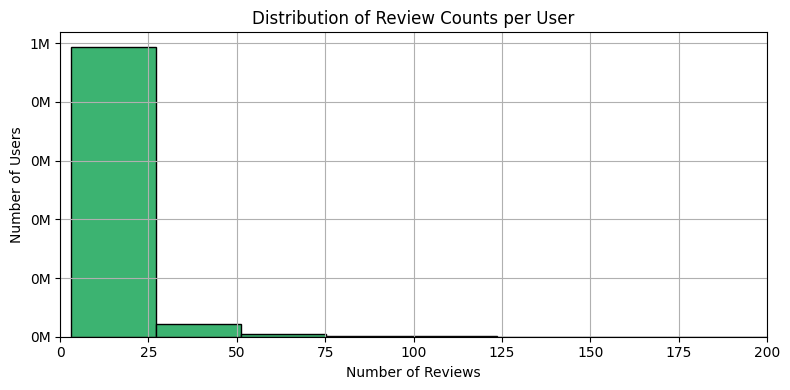

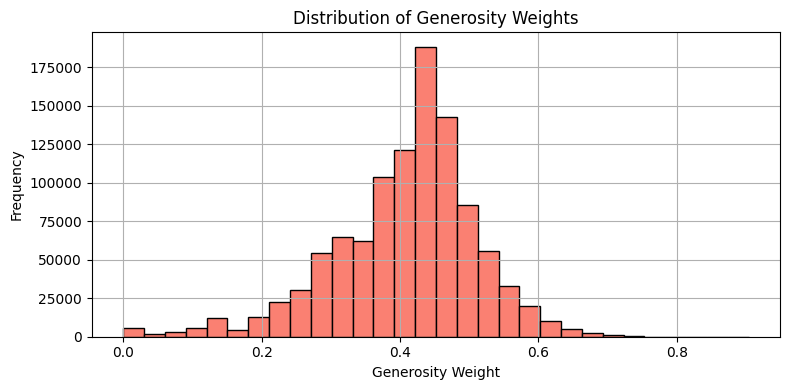

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Formatter to show y-axis in millions
def millions(x, pos):
    return f'{int(x / 1e6)}M'

plt.figure(figsize=(8, 4))
plt.hist(user_stats['n_reviews'], bins=50, color='mediumseagreen', edgecolor='black')

# Cap x-axis to focus on typical users
plt.xlim(0, 200)  # adjust as needed to exclude long tail

# Format y-axis ticks
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))

plt.title("Distribution of Review Counts per User")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Users")
plt.grid(True)
plt.tight_layout()
plt.show()

# Generosity weight distribution
plt.figure(figsize=(8, 4))
plt.hist(user_stats['generosity_weight'], bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Generosity Weights")
plt.xlabel("Generosity Weight")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()
